# Analyse du discours des Banques Centrales

In [1]:
import datetime
import copy as c
import random
import collections
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
#!pip install spacy
import spacy
#!pip install langdetect
import langdetect
import nltk
from nltk.corpus import stopwords
import plotly

In [2]:
url="https://www.ecb.europa.eu/press/key/shared/data/all_ECB_speeches.csv?5f1650f87c081c670b20cc03e741c558"

#le fichier de janvier contient 4 discours de plus que celui de décembre

url_december="https://www.ecb.europa.eu/press/key/shared/data/all_ECB_speeches.csv?848ea64ce6d77827b5e8e18790878b64"
# a priori les anciens liens restent utilisables
df=pd.read_csv(url,sep = "|",encoding='utf-8')

# Une connexion lente peut obliger à télécharger le fichier en local
url_local=r"C:\Users\Antoine\Downloads\all_ECB_speeches.csv"
#df=pd.read_csv(url_local,sep = "|",encoding='utf-8')

# fichier mis à jour tous les mois, dernière version : 1er janvier 2022 (49,1 Mo)
# à récupérer à l'adresse : https://www.ecb.europa.eu/press/key/html/downloads.en.html
# plus de 2500 discours de responsables de la BCE entre 1997 et 2021

In [3]:
df

date              speakers  \
0     2021-12-10         Fabio Panetta   
1     2021-12-08       Isabel Schnabel   
2     2021-12-08       Luis de Guindos   
3     2021-12-08     Christine Lagarde   
4     2021-11-29     Christine Lagarde   
...          ...                   ...   
2548  1997-05-13  Alexandre Lamfalussy   
2549  1997-04-30  Alexandre Lamfalussy   
2550  1997-04-22  Alexandre Lamfalussy   
2551  1997-03-10  Alexandre Lamfalussy   
2552  1997-02-07  Alexandre Lamfalussy   

                                                  title  \
0     The present and future of money in the digital...   
1               Monetary policy and financial stability   
2     Macroprudential policy for non-bank financial ...   
3     Macroprudential policy in Europe – the future ...   
4                          Dialogue in a changing world   
...                                                 ...   
2548  The European Central Bank: independent and acc...   
2549  The operation of monetary policy in stage thre...   
2550  Convergence and the role of the European Centr...   
2551                       Securing the benefits of EMU   
2552  Conference organised by the Hungarian Banking ...   

                                               subtitle  \
0     Lecture by Fabio Panetta, Member of the Execut...   
1     Speech by Isabel Schnabel, Member of the Execu...   
2     Speech by Luis de Guindos, Vice-President of t...   
3     Welcome remarks by Christine Lagarde, Presiden...   
4     Lectio Magistralis by Christine Lagarde, Presi...   
...                                                 ...   
2548  Keynote speech delivered by Alexandre Lamfalus...   
2549  Address by Alexandre Lamfalussy, President of ...   
2550  Remarks by Alexandre Lamfalussy, President of ...   
2551  Address by Alexandre Lamfalussy, President of ...   
2552  Address by Alexandre Lamfalussy, President of ...   

                                               contents  
0        SPEECH  The present and future of money in ...  
1        SPEECH  Monetary policy and financial stabi...  
2        SPEECH  Macroprudential policy for non-bank...  
3        SPEECH  Macroprudential policy in Europe – ...  
4        SPEECH  Dialogue in a changing world   Lect...  
...                                                 ...  
2548    The European Central Bank: independent and a...  
2549    The operation of monetary policy in stage th...  
2550    Convergence and the role of the European Cen...  
2551    Securing the benefits of EMU   Address by Al...  
2552    Conference organised by the Hungarian Bankin...  

[2553 rows x 5 columns]

In [4]:
print(df.isna().sum())
# on affiche un dataframe avec toutes les lignes contenant au moins un NaN
#df[df.isna().any(axis=1)] 

date         0
speakers     2
title        0
subtitle     1
contents    39
dtype: int64


On remarque que pour tous les discours, on a seulement le titre et le speaker mais le contenu est NaN. Il faut donc mettre de côté tous ces discours sans contenu. Ce cas se présente seulement pour 39 discours (soit 1,5% de la base de données).

In [5]:
df=df.dropna(axis='index',how='any')
df=df.reset_index(drop=True)

In [6]:
df.head()

date           speakers  \
0  2021-12-10      Fabio Panetta   
1  2021-12-08    Isabel Schnabel   
2  2021-12-08    Luis de Guindos   
3  2021-12-08  Christine Lagarde   
4  2021-11-29  Christine Lagarde   

                                               title  \
0  The present and future of money in the digital...   
1            Monetary policy and financial stability   
2  Macroprudential policy for non-bank financial ...   
3  Macroprudential policy in Europe – the future ...   
4                       Dialogue in a changing world   

                                            subtitle  \
0  Lecture by Fabio Panetta, Member of the Execut...   
1  Speech by Isabel Schnabel, Member of the Execu...   
2  Speech by Luis de Guindos, Vice-President of t...   
3  Welcome remarks by Christine Lagarde, Presiden...   
4  Lectio Magistralis by Christine Lagarde, Presi...   

                                            contents  
0     SPEECH  The present and future of money in ...  
1     SPEECH  Monetary policy and financial stabi...  
2     SPEECH  Macroprudential policy for non-bank...  
3     SPEECH  Macroprudential policy in Europe – ...  
4     SPEECH  Dialogue in a changing world   Lect...

#### En explorant le dataset, on se rend compte que certains contenus de discours sont vides (plusieurs espaces mais pas NaN).
#### Il faut donc retirer ces lignes du dataframe.

In [7]:
L=[]
for i in range(len(df)):
    if not bool(df["contents"][i].strip()): #si le contenu du discours est vide
        L.append(i)
L # ne concerne qu'une ligne

[2013]

In [8]:
df=df.drop(L).reset_index(drop=True)
df

date              speakers  \
0     2021-12-10         Fabio Panetta   
1     2021-12-08       Isabel Schnabel   
2     2021-12-08       Luis de Guindos   
3     2021-12-08     Christine Lagarde   
4     2021-11-29     Christine Lagarde   
...          ...                   ...   
2508  1997-05-13  Alexandre Lamfalussy   
2509  1997-04-30  Alexandre Lamfalussy   
2510  1997-04-22  Alexandre Lamfalussy   
2511  1997-03-10  Alexandre Lamfalussy   
2512  1997-02-07  Alexandre Lamfalussy   

                                                  title  \
0     The present and future of money in the digital...   
1               Monetary policy and financial stability   
2     Macroprudential policy for non-bank financial ...   
3     Macroprudential policy in Europe – the future ...   
4                          Dialogue in a changing world   
...                                                 ...   
2508  The European Central Bank: independent and acc...   
2509  The operation of monetary policy in stage thre...   
2510  Convergence and the role of the European Centr...   
2511                       Securing the benefits of EMU   
2512  Conference organised by the Hungarian Banking ...   

                                               subtitle  \
0     Lecture by Fabio Panetta, Member of the Execut...   
1     Speech by Isabel Schnabel, Member of the Execu...   
2     Speech by Luis de Guindos, Vice-President of t...   
3     Welcome remarks by Christine Lagarde, Presiden...   
4     Lectio Magistralis by Christine Lagarde, Presi...   
...                                                 ...   
2508  Keynote speech delivered by Alexandre Lamfalus...   
2509  Address by Alexandre Lamfalussy, President of ...   
2510  Remarks by Alexandre Lamfalussy, President of ...   
2511  Address by Alexandre Lamfalussy, President of ...   
2512  Address by Alexandre Lamfalussy, President of ...   

                                               contents  
0        SPEECH  The present and future of money in ...  
1        SPEECH  Monetary policy and financial stabi...  
2        SPEECH  Macroprudential policy for non-bank...  
3        SPEECH  Macroprudential policy in Europe – ...  
4        SPEECH  Dialogue in a changing world   Lect...  
...                                                 ...  
2508    The European Central Bank: independent and a...  
2509    The operation of monetary policy in stage th...  
2510    Convergence and the role of the European Cen...  
2511    Securing the benefits of EMU   Address by Al...  
2512    Conference organised by the Hungarian Bankin...  

[2513 rows x 5 columns]

#### On se rend compte que certains discours ne sont pas en anglais.
#### Il faut donc les retirer.

On teste différentes méthodes de détection de langue. Ces tests se trouvent dans le notebook *Tests-LanguageDetection.ipynb*.

On utilise ici la méthode qu'on juste la plus adaptée à notre projet alliant rapidité et une efficacité convenable : on analyse les 2000 premiers caractères des discours avec la fonction *detect* de la librairie langdetect.

In [9]:
# Extrait de la documentation https://pypi.org/project/langdetect/#description
# langdetect Language detection algorithm is non-deterministic,
# which means that if you try to run it on a text which is either too short or too ambiguous,
# you might get different results everytime you run it.
# To enforce consistent results, call following code before the first language detection:

langdetect.DetectorFactory.seed = 0

In [10]:
start = time.time()
EN=0 #nombre de discours en anglais
OTHERS=0 #nombre de discours dans d'autres langues
M=[] #liste de chaines de caractères avec les langues détectées (autres que l'anglais)
I=[] #liste de numéros de lignes des discours qui ne sont pas en anglais
s=''
n=len(df) #longueur du dataframe 

for i in range(n):
    s=langdetect.detect(df["contents"][i][:2000])
    if s=='en': #si la langue détectée est l'anglais
        EN+=1
    else: #si l'on détecte une autre langue majoritaire
        OTHERS+=1
        M.append(s)
        I.append(i)
print("Proportion de discours en anglais : ", EN/n)
end = time.time()
print("Temps pris par cette méthode :", end - start) 

"""
Proportion de discours en anglais :  0.9294539657233958
Temps pris par cette méthode : 19.53878378868103
"""

Proportion de discours en anglais :  0.9287703939514524
Temps pris par cette méthode : 23.125797510147095


'\nProportion de discours en anglais :  0.9294539657233958\nTemps pris par cette méthode : 19.53878378868103\n'

### Modification du dataframe

In [11]:
#df["Language"]=pd.Series(dtype=str)
#On pourrait ajouter une colonne "language" pour une analyse ultérieure
#si on veut conserver les discours dans toutes les langues

In [12]:
# On retire les discours qui ne sont pas en anglais des données à analyser
df=df.drop(I).reset_index(drop=True)
df

date              speakers  \
0     2021-12-10         Fabio Panetta   
1     2021-12-08       Isabel Schnabel   
2     2021-12-08       Luis de Guindos   
3     2021-12-08     Christine Lagarde   
4     2021-11-29     Christine Lagarde   
...          ...                   ...   
2329  1997-05-13  Alexandre Lamfalussy   
2330  1997-04-30  Alexandre Lamfalussy   
2331  1997-04-22  Alexandre Lamfalussy   
2332  1997-03-10  Alexandre Lamfalussy   
2333  1997-02-07  Alexandre Lamfalussy   

                                                  title  \
0     The present and future of money in the digital...   
1               Monetary policy and financial stability   
2     Macroprudential policy for non-bank financial ...   
3     Macroprudential policy in Europe – the future ...   
4                          Dialogue in a changing world   
...                                                 ...   
2329  The European Central Bank: independent and acc...   
2330  The operation of monetary policy in stage thre...   
2331  Convergence and the role of the European Centr...   
2332                       Securing the benefits of EMU   
2333  Conference organised by the Hungarian Banking ...   

                                               subtitle  \
0     Lecture by Fabio Panetta, Member of the Execut...   
1     Speech by Isabel Schnabel, Member of the Execu...   
2     Speech by Luis de Guindos, Vice-President of t...   
3     Welcome remarks by Christine Lagarde, Presiden...   
4     Lectio Magistralis by Christine Lagarde, Presi...   
...                                                 ...   
2329  Keynote speech delivered by Alexandre Lamfalus...   
2330  Address by Alexandre Lamfalussy, President of ...   
2331  Remarks by Alexandre Lamfalussy, President of ...   
2332  Address by Alexandre Lamfalussy, President of ...   
2333  Address by Alexandre Lamfalussy, President of ...   

                                               contents  
0        SPEECH  The present and future of money in ...  
1        SPEECH  Monetary policy and financial stabi...  
2        SPEECH  Macroprudential policy for non-bank...  
3        SPEECH  Macroprudential policy in Europe – ...  
4        SPEECH  Dialogue in a changing world   Lect...  
...                                                 ...  
2329    The European Central Bank: independent and a...  
2330    The operation of monetary policy in stage th...  
2331    Convergence and the role of the European Cen...  
2332    Securing the benefits of EMU   Address by Al...  
2333    Conference organised by the Hungarian Bankin...  

[2334 rows x 5 columns]

En nettoyant le jeu de données, on conserve plus de 90% des discours (pour les données mises à jour le 1er décembre 2021, 2330 discours sur 2549), ce qui est tout à fait satisfaisant.

In [13]:
df.sample(5)
#a priori ces discours sont bien en anglais

date                  speakers  \
882   2013-10-11              Mario Draghi   
2026  2002-04-29              Otmar Issing   
1263  2010-05-20       Jean-Claude Trichet   
1777  2005-10-03  Gertrude Tumpel-Gugerell   
700   2015-07-02               Yves Mersch   

                                                  title  \
882   Euro area economic outlook, the ECB's monetary...   
2026  Monetary policy in an environment of global fi...   
1263  The great financial crisis: Lessons for financ...   
1777  Keeping up the momentum: achieving the SEPA ob...   
700    Translating a shared vision into a winning story   

                                               subtitle  \
882   Statement by Mario Draghi, President of the EC...   
2026  Professor Otmar Issing, Launching Workshop of ...   
1263  Introductory remarks by Jean-Claude Trichet, P...   
1777  Gertrude Tumpel-Gugerell Member of the Executi...   
700   Closing Remarks at the T2S launch celebration ...   

                                               contents  
882     Euro area economic outlook, the ECB’s moneta...  
2026    Monetary policy in an environment of global ...  
1263    The great financial crisis: Lessons for fina...  
1777    Keeping up the momentum: achieving the SEPA ...  
700     Translating a shared vision into a winning s...

### Ajout de colonnes Jour, Mois, Année au dataframe

Pour les premières étapes de statistiques descriptives du dataframe, il parait pertinent de créer d'autres colonnes à partir de la colonne "date" pour faciliter la manipulation des données.

On crée donc trois colonnes pour le jour, le mois et l'année qu'on établit à partir de "date".

In [14]:

df["Year"]=df.date.str[:4].astype(int)
df["Month"]=df.date.str[5:7].astype(int)
df["Day"]=df.date.str[8:].astype(int)


Puis on ajoute le mois et le jour de la semaine (de type str).

In [15]:
week=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
months=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df["DayofWeek"]=pd.Series(dtype=int)
df["DayofWeek_str"]=pd.Series(dtype=str)
df["Month_str"]=pd.Series(dtype=str)
for i in range(len(df)):
    df["DayofWeek"][i]=int(datetime.date(df["Year"][i],df["Month"][i],df["Day"][i]).isoweekday())
    df["DayofWeek_str"][i]=week[int(datetime.date(df["Year"][i],df["Month"][i],df["Day"][i]).weekday())]
    df["Month_str"][i]=months[df["Month"][i]-1]

#.weekday() : from 0 to 6
#.isoweekday() : from 1 to 7

df["DayofWeek"]=df["DayofWeek"].astype(int)

C:\Users\Antoine\AppData\Local\Temp/ipykernel_17796/494173469.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DayofWeek"][i]=int(datetime.date(df["Year"][i],df["Month"][i],df["Day"][i]).isoweekday())
C:\Users\Antoine\AppData\Local\Temp/ipykernel_17796/494173469.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DayofWeek_str"][i]=week[int(datetime.date(df["Year"][i],df["Month"][i],df["Day"][i]).weekday())]
C:\Users\Antoine\AppData\Local\Temp/ipykernel_17796/494173469.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https

In [16]:
df.sample(5)

date                     speakers  \
1742  2006-03-01  José Manuel González-Páramo   
720   2015-04-23                  Peter Praet   
230   2019-05-16              Luis de Guindos   
605   2016-05-09             Vítor Constâncio   
1215  2010-10-16          Jean-Claude Trichet   

                                                  title  \
1742  The importance of high quality cross-border po...   
720           Lifting potential growth in the euro area   
230   Deepening EMU and the implications for the int...   
605                  The outlook for the Global Economy   
1215  Global economic governance  and euro area econ...   

                                               subtitle  \
1742  Keynote address José Manuel González-Páramo, M...   
720   Speech by Peter Praet, Member of the Executive...   
230   Speech by Luis de Guindos, Vice-President of t...   
605   Remarks by Vítor Constâncio, Vice-President of...   
1215  Speech by Jean-Claude Trichet, President of th...   

                                               contents  Year  Month  Day  \
1742    The importance of high quality cross-border ...  2006      3    1   
720     Lifting potential growth in the euro area   ...  2015      4   23   
230     Deepening EMU and the implications for the i...  2019      5   16   
605     The outlook for the Global Economy   Remarks...  2016      5    9   
1215    Global economic governance 
and euro area ec...  2010     10   16   

      DayofWeek DayofWeek_str Month_str  
1742          3     Wednesday     March  
720           4      Thursday     April  
230           4      Thursday       May  
605           1        Monday       May  
1215          6      Saturday   October

### Copie locale du dataset

Pour les analyses ultérieures, il peut être utile de disposer en local d'un fichier .csv avec le jeu de données "nettoyé" pour ne pas avoir à réexécuter le code précédent avant.

In [17]:
#pour obtenir une copie locale du dataset "nettoyé"
path=r"C:\Users\Antoine\Downloads\clean_ecb_speeches_dataset.csv"
df.to_csv(path_or_buf=path,
          sep=',',
          header=True,
          index=False,
          encoding='utf-8'
         )

## Première analyse des données 

### Répartition des discours dans le temps

Une première étape de l'analyse du jeu de données qui parait pertinente est l'observation de la répartition des discours dans le temps selon les années, les mois et les jours.

#### Nombre de discours par an

<AxesSubplot:title={'center':'Evolution du nombre annuel de discours du Comité Exécutif de la BCE'}, xlabel='Année'>

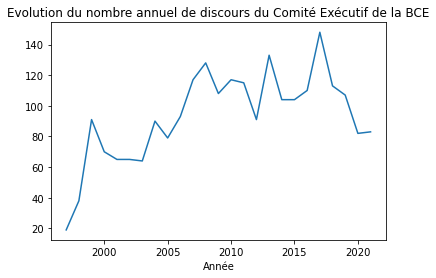

In [18]:
df_year=df.groupby("Year").count()
df_year["date"].plot(title='Evolution du nombre annuel de discours du Comité Exécutif de la BCE', xlabel="Année")

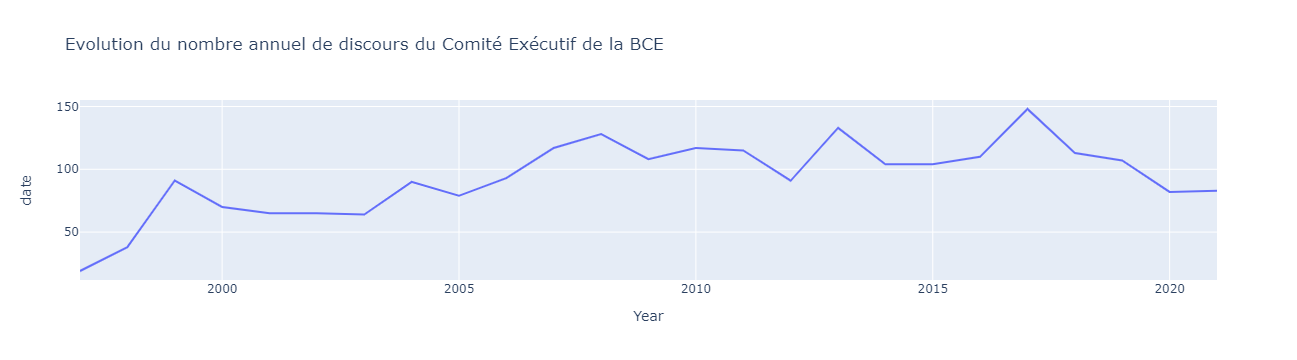

In [19]:
df_year.plot(y="date",title='Evolution du nombre annuel de discours du Comité Exécutif de la BCE', backend='plotly')

In [20]:
df.groupby("Year").count()

date  speakers  title  subtitle  contents  Month  Day  DayofWeek  \
Year                                                                     
1997    19        19     19        19        19     19   19         19   
1998    38        38     38        38        38     38   38         38   
1999    91        91     91        91        91     91   91         91   
2000    70        70     70        70        70     70   70         70   
2001    65        65     65        65        65     65   65         65   
2002    65        65     65        65        65     65   65         65   
2003    64        64     64        64        64     64   64         64   
2004    90        90     90        90        90     90   90         90   
2005    79        79     79        79        79     79   79         79   
2006    93        93     93        93        93     93   93         93   
2007   117       117    117       117       117    117  117        117   
2008   128       128    128       128       128    128  128        128   
2009   108       108    108       108       108    108  108        108   
2010   117       117    117       117       117    117  117        117   
2011   115       115    115       115       115    115  115        115   
2012    91        91     91        91        91     91   91         91   
2013   133       133    133       133       133    133  133        133   
2014   104       104    104       104       104    104  104        104   
2015   104       104    104       104       104    104  104        104   
2016   110       110    110       110       110    110  110        110   
2017   148       148    148       148       148    148  148        148   
2018   113       113    113       113       113    113  113        113   
2019   107       107    107       107       107    107  107        107   
2020    82        82     82        82        82     82   82         82   
2021    83        83     83        83        83     83   83         83   

      DayofWeek_str  Month_str  
Year                            
1997             19         19  
1998             38         38  
1999             91         91  
2000             70         70  
2001             65         65  
2002             65         65  
2003             64         64  
2004             90         90  
2005             79         79  
2006             93         93  
2007            117        117  
2008            128        128  
2009            108        108  
2010            117        117  
2011            115        115  
2012             91         91  
2013            133        133  
2014            104        104  
2015            104        104  
2016            110        110  
2017            148        148  
2018            113        113  
2019            107        107  
2020             82         82  
2021             83         83

<AxesSubplot:title={'center':'Nombre de discours du Comité Exécutif de la BCE par an'}, xlabel='Année'>

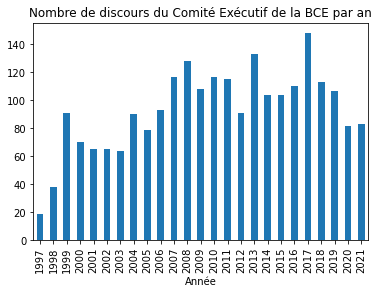

In [21]:
df_year=df.groupby("Year").count()
df_year["date"].plot(kind='bar',title='Nombre de discours du Comité Exécutif de la BCE par an', xlabel="Année")

Depuis la création de la Banque Centrale européenne, on constate une hausse significative du nombre de discours du comité exécutif de la BCE : aucune année ne dépasse 100 discours jusqu'en 2006 alors que depuis le nombre de discours n'a été inférieur à 100 qu'en 2012, 2020 et 2021, avec une situation exceptionnelle (crise sanitaire mondiale) pour ces deux dernières années. On pourrait émettre l'hypothèse que les pics du graphique correspondent aux crises : crise des subprimes en 2008, Brexit en 2017 par exemple.

#### Nombre de discours selon les mois 

<AxesSubplot:title={'center':"Nombre de discours par mois de l'année"}, xlabel='Month'>

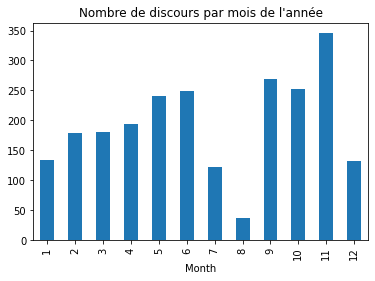

In [22]:
df_month=df.groupby("Month").count()
df_month["date"].plot(kind='bar', title="Nombre de discours par mois de l'année")

<AxesSubplot:title={'center':"Nombre de discours par mois de l'année"}, xlabel='Month'>

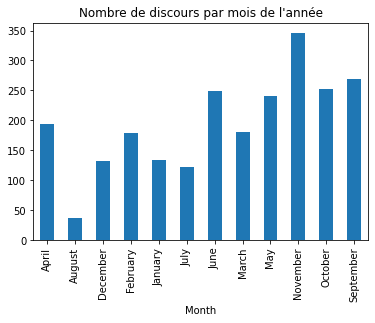

In [23]:
df_month=df.groupby("Month_str").count()
df_month["date"].plot(kind='bar', title="Nombre de discours par mois de l'année", xlabel='Month')

Text(0.5, 1.0, 'On which month are ECB speeches delivered?')

<Figure size 432x288 with 0 Axes>

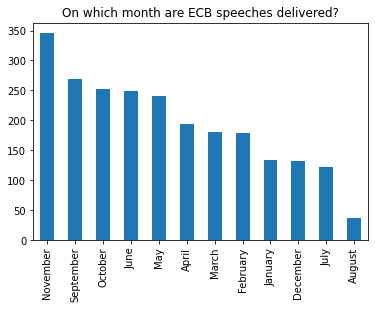

In [24]:
plt.clf()
plt.figure()

df["Month_str"].value_counts().plot(kind="bar")
plt.title("On which month are ECB speeches delivered?")

In [25]:
#Les mois ne sont pas ordonnés dans l'ordre chronologique mais ordre décroissant du nombre de discours.

On constate une forte saisonnalité des discours à la BCE : la plupart des discours sont prononcés pendant les trois mois de la "rentrée" (septembre, octobre, novembre) avec un maximum en novembre mais aussi dans une moindre mesure pendant les trois mois avant l'été (avril, mai, juin). Le nombre de discours chute pendant la période des vacances d'été (juillet et août), particulièrement en août.

#### Nombre de discours selon les jours du mois

<AxesSubplot:title={'center':'Nombre de discours de la BCE selon les jours du mois'}, xlabel='Jour'>

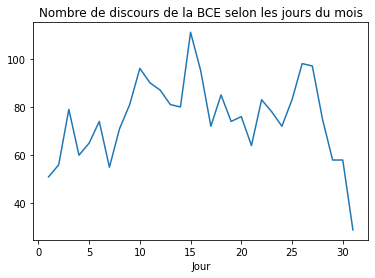

In [26]:
df_day=df.groupby("Day").count()
df_day["date"].plot(title="Nombre de discours de la BCE selon les jours du mois", xlabel='Jour')

<AxesSubplot:title={'center':'Nombre de discours de la BCE selon les jours du mois'}, xlabel='Jour'>

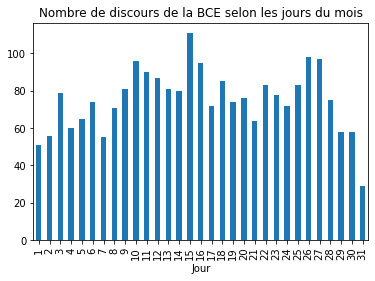

In [27]:
df_day=df.groupby("Day").count()
df_day["date"].plot(kind='bar', title="Nombre de discours de la BCE selon les jours du mois", xlabel='Jour')

#### Nombre de discours selon les jours de la semaine

<AxesSubplot:title={'center':'Nombre de discours de la BCE selon le jour de la semaine'}, xlabel='Jour de la semaine'>

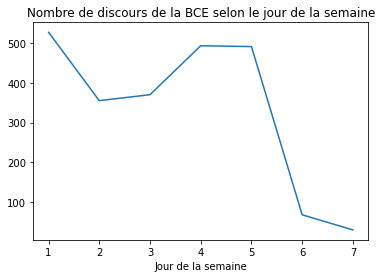

In [28]:
df_day=df.groupby("DayofWeek").count()
df_day["date"].plot(title="Nombre de discours de la BCE selon le jour de la semaine", xlabel="Jour de la semaine")

<AxesSubplot:title={'center':'Nombre de discours de la BCE selon le jour de la semaine'}, xlabel='Jour de la semaine'>

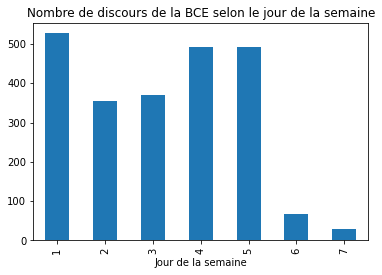

In [29]:
df_day=df.groupby("DayofWeek").count()
df_day["date"].plot(kind="bar",title="Nombre de discours de la BCE selon le jour de la semaine", xlabel="Jour de la semaine")

On remarque que les discours de la BCE de notre échantillon ne sont pas répartis identiquement selon les jours de la semaine : ils sont majoritairement prononcés le premier jour de la semaine (lundi) et les deux jours avant le week-end (jeudi et vendredi), avec une chute conséquente le samedi et le dimanche, qui sont aussi les jours de fermeture des marchés boursiers dans le monde.

In [30]:
n_dates=df["date"].nunique()
print("Il y a",
      n_dates,
      "dates distinctes dans ce jeu de données, soit en moyenne environ",
      round(n_dates/len(df),3),
      "discours par jour.")

Il y a 1807 dates distinctes dans ce jeu de données, soit en moyenne environ 0.774 discours par jour.


<AxesSubplot:>

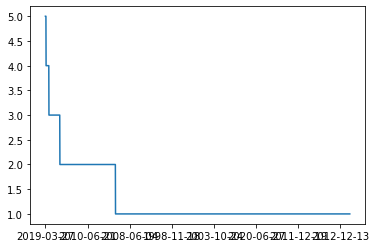

In [31]:

df["date"].value_counts().plot()
# Graphique très laid mais qui permet de voir qu'il y a un nombre de jours non négligeable pour lesquels il y a eu plusieurs discours


In [32]:
#Pour aller plus loin dans l'analyse du nombre de discours par jour
print("Il y a",
      (df["date"].value_counts()>=2).sum(),
      "jours pour lesquels plus qu'un seul discours, soit",
      round(((df["date"].value_counts()>=2).sum()/n_dates)*100,2),
      "% de l'échantillon étudié.")

print("Il y a",
      (df["date"].value_counts()==2).sum(),
      "jours pour lesquels on a 2 discours.")
print("Il y a",
      (df["date"].value_counts()==3).sum(),
      "jours pour lesquels on a 3 discours.")
print("Il y a",
      (df["date"].value_counts()==4).sum(),
      "jours pour lesquels on a 4 discours.")
print("Il y a",
      (df["date"].value_counts()==5).sum(),
      "jours pour lesquels on a 5 discours.")

Il y a 416 jours pour lesquels plus qu'un seul discours, soit 23.02 % de l'échantillon étudié.
Il y a 330 jours pour lesquels on a 2 discours.
Il y a 65 jours pour lesquels on a 3 discours.
Il y a 17 jours pour lesquels on a 4 discours.
Il y a 4 jours pour lesquels on a 5 discours.


In [33]:
array=df["DayofWeek"].value_counts().to_numpy()
array

array([527, 493, 491, 370, 355,  68,  30], dtype=int64)

Text(0.5, 1.0, 'Top 15 ECB Speakers')

<Figure size 432x288 with 0 Axes>

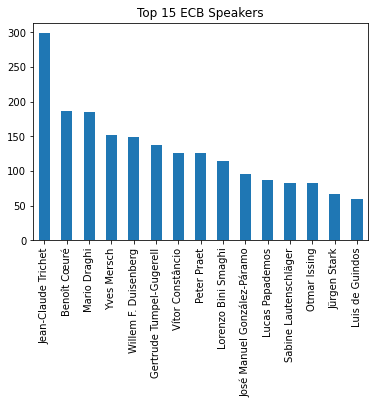

In [34]:
plt.clf()
plt.figure()

df["speakers"].value_counts()[:15].plot(kind="bar")

plt.title("Top 15 ECB Speakers")

## Début de l'analyse pour le NLP

In [35]:
rawtext=''
L=random.sample(range(len(df)),5)
for i in L:
    rawtext+=df["title"][i]+df["contents"][i]
# On commence par analyser 15 discours choisis au hasard 

In [36]:
rawtext[:500]

"Europe's pursuit of ‘a more perfect Union'  Europe’s pursuit of ‘a more perfect Union’    Lecture by Mario Draghi, President of the ECB,at Harvard Kennedy School,Cambridge (USA), 9 October 2013   Introduction Ladies and gentlemen, I am delighted to have been invited to give this year’s Malcolm Wiener lecture on international political economy. It is always a pleasure to be back in this country, particularly here in Cambridge where I studied for my PhD back in the 1970s. The United States has oft"

In [37]:
# Reconnaissance des entités nommées

nlp = spacy.load("en_core_web_lg")
doc = nlp(rawtext)
spacy.displacy.render(doc, style="ent", jupyter=True)

In [38]:
#Il faut définir un liste de stopwords (c'est-à-dire de mots non significatifs) 
#En anglais 
#from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [39]:

alphabet=set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ') #type(alphabet)=set "ensemble"
stop_words= stop_words | alphabet # On fait une union d'ensembles pour retirer des nuages de mots les lettres isolées
#L'étape précédeente peut êtr évitée en spécifiant min_word_length=2 dans la fonction WordCloud
wordlist=['The','It','And','this','This','The','the','these','These','those','Those','In','&','one','He','She','he','she','it','\\displaystyle','\\mathbb','\\neg','per','th','also','would','de','la']
stop_words.update(wordlist) #on ajoute des mots aux 'stopwords'

In [40]:
#Fonction qui permet d'obtenir une liste de mots en minuscules sans les stopwords

def str_to_wordlist(text):
    text2 = c.copy(text)
    text2 = text2.lower() # minuscules
    text2 = re.sub(r'\d+','',text2) # enlever les nombres
    text2 = re.findall(r'\w+', text2) # enlever la ponctuation
    text2 = [word for word in text2 if not word in stop_words and len(word)>2] # enlever les stopwords
    return(text2)

#text = str_to_wordlist(text)

In [41]:
def freq_dict(text):
    res = {}
    for word in text:
        try:
            res[word] += 1
        except KeyError:
            res[word] = 1
    return(res)


#dictionary = freq_dict(rawtext)

In [42]:
"Fonction pour récupérer les fréquences des mots d'un texte"

def freq_mots(text,stopwords):
    text = re.sub(r'==.*?==+', ' ', text)
    text = text.replace('\n', ' ')
    text=text.replace('\'',' ')
    text=re.sub(r'[^\w\s]',' ',text) #retire la ponctuation
    text = re.sub(r'\d+','',text) #retire les nombres
    text=text.replace('%',' ')
    text=text.replace('+',' ')
    text=text.replace('=',' ')
    text=text.replace('*',' ')
    text=text.replace('_',' ')
    text=text.replace('-',' ')
    T=[mot for mot in text.split() if mot not in list(stopwords)]
    return collections.Counter(T)


In [43]:
freq_mots(rawtext,stop_words)

Counter({'Europe': 32,
         'pursuit': 3,
         'perfect': 3,
         'Union': 13,
         'Lecture': 1,
         'Mario': 2,
         'Draghi': 2,
         'President': 11,
         'ECB': 88,
         'Harvard': 1,
         'Kennedy': 1,
         'School': 1,
         'Cambridge': 2,
         'USA': 1,
         'October': 7,
         'Introduction': 2,
         'Ladies': 3,
         'gentlemen': 3,
         'delighted': 1,
         'invited': 2,
         'give': 25,
         'year': 29,
         'Malcolm': 1,
         'Wiener': 1,
         'lecture': 1,
         'international': 5,
         'political': 10,
         'economy': 53,
         'always': 7,
         'pleasure': 4,
         'back': 9,
         'country': 16,
         'particularly': 10,
         'studied': 3,
         'PhD': 1,
         'United': 16,
         'States': 28,
         'often': 6,
         'described': 4,
         'young': 2,
         'nation': 1,
         'institution': 5,
         'honour': 1,
     

In [44]:
"Fonction pour récupérer la liste des mots d'un texte brut"
def liste_mots(text,stopwords):
    text = re.sub(r'==.*?==+', ' ', text)
    text = text.replace('\n', ' ')
    text=text.replace('\'',' ')
    text=re.sub(r'[^\w\s]',' ',text) #retire la ponctuation
    text = re.sub(r'\d+',' ',text) #retire les nombres
    text=text.replace('%',' ')
    text=text.replace('+',' ')
    text=text.replace('=',' ')
    text=text.replace('*',' ')
    text=text.replace('_',' ')
    text=text.replace('-',' ')
    return [mot for mot in text.split() if mot not in list(stopwords)]

In [45]:
liste_mots(rawtext,stop_words)

['Europe',
 'pursuit',
 'perfect',
 'Union',
 'Europe',
 'pursuit',
 'perfect',
 'Union',
 'Lecture',
 'Mario',
 'Draghi',
 'President',
 'ECB',
 'Harvard',
 'Kennedy',
 'School',
 'Cambridge',
 'USA',
 'October',
 'Introduction',
 'Ladies',
 'gentlemen',
 'delighted',
 'invited',
 'give',
 'year',
 'Malcolm',
 'Wiener',
 'lecture',
 'international',
 'political',
 'economy',
 'always',
 'pleasure',
 'back',
 'country',
 'particularly',
 'Cambridge',
 'studied',
 'PhD',
 'back',
 'United',
 'States',
 'often',
 'described',
 'young',
 'nation',
 'institution',
 'honour',
 'leading',
 'considerably',
 'younger',
 'European',
 'Central',
 'Bank',
 'ECB',
 'single',
 'currency',
 'began',
 'operations',
 'nearly',
 'years',
 'ago',
 'beginning',
 'Today',
 'like',
 'give',
 'flavour',
 'circumstances',
 'beginnings',
 'challenging',
 'environment',
 'teenage',
 'years',
 'As',
 'aware',
 'Europe',
 'currently',
 'engaged',
 'far',
 'reaching',
 'process',
 'reform',
 'Many',
 'reforms',
 

In [46]:
"Fonction pour récupérer les n mots les plus fréquents (hors stopwords) dans un texte brut"
def plus_frequents(text,n,stopwords):
    L=[]
    text = re.sub(r'==.*?==+', ' ', text)
    text = text.replace('\n', ' ')
    text=text.replace('\'',' ')
    text=re.sub(r'[^\w\s]',' ',text) #retire la ponctuation
    text = re.sub(r'\d+',' ',text) #retire les nombres
    text=text.replace('%',' ')
    text=text.replace('+',' ')
    text=text.replace('=',' ')
    text=text.replace('*',' ')
    text=text.replace('_',' ')
    text=text.replace('-',' ')
    T=[mot for mot in text.split() if mot not in list(stopwords)]
    for tuple in collections.Counter(T).most_common(n):
        L.append([tuple[0],tuple[1]])
    return L

In [47]:
n=20
plus_frequents(rawtext,n,stop_words)

[['euro', 195],
 ['area', 147],
 ['financial', 111],
 ['policy', 104],
 ['Mr', 104],
 ['rate', 95],
 ['monetary', 93],
 ['ECB', 88],
 ['market', 74],
 ['rates', 73],
 ['interest', 70],
 ['economic', 64],
 ['European', 62],
 ['We', 59],
 ['banks', 57],
 ['Duisenberg', 54],
 ['measures', 54],
 ['economy', 53],
 ['US', 53],
 ['could', 51]]

In [48]:
rawtext=''
L=random.sample(range(len(df)),50)
for i in L:
    rawtext+=df["title"][i]+df["contents"][i]
# On commence par analyser 15 discours choisis au hasard 

In [49]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

#tokenizer.tokenize('Eighty-seven miles to go, yet.  Onward!')

#example_sent = "This is a sample sentence,showing off the stop words filtration."

def tokens_filter(text,stop_words):
    word_tokens = tokenizer.tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words] #retire les stopwords
    return filtered_sentence

text=tokens_filter(rawtext,stop_words)

In [50]:
collections.Counter(text).most_common(20)

[('euro', 1016),
 ('policy', 949),
 ('monetary', 783),
 ('area', 765),
 ('financial', 726),
 ('ECB', 669),
 ('banks', 503),
 ('market', 475),
 ('economic', 447),
 ('countries', 444),
 ('central', 411),
 ('inflation', 392),
 ('European', 387),
 ('term', 372),
 ('stability', 349),
 ('price', 325),
 ('rates', 317),
 ('growth', 299),
 ('bank', 290),
 ('rate', 285)]

## les n-grams

In [51]:
nltk.download('genesis')
nltk.corpus.genesis.words('english-web.txt')

[nltk_data] Downloading package genesis to
[nltk_data]     C:\Users\Antoine\AppData\Roaming\nltk_data...
[nltk_data]   Package genesis is already up-to-date!


['In', 'the', 'beginning', 'God', 'created', 'the', ...]

In [52]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()

## Bigrams
finder = BigramCollocationFinder.from_words(
   text)
# only bigrams that appear 3+ times
finder.apply_freq_filter(3)


# return the 10 n-grams with the highest PMI
# print (finder.nbest(bigram_measures.likelihood_ratio, 10))

for i in finder.score_ngrams(bigram_measures.likelihood_ratio):
    print (i)

(('euro', 'area'), 6250.531604719675)
(('monetary', 'policy'), 4213.056094807414)
(('price', 'stability'), 1719.9075240439747)
(('Governing', 'Council'), 1447.834686020781)
(('central', 'bank'), 1424.649636100658)
(('interest', 'rates'), 1399.4634160123583)
(('central', 'banks'), 1364.7688827504905)
(('medium', 'term'), 1149.6323729002102)
(('Member', 'States'), 1068.007562245048)
(('balance', 'sheet'), 817.3834994468157)
(('short', 'term'), 789.6104039105311)
(('long', 'term'), 751.5416924007445)
(('Executive', 'Board'), 679.8873687204804)
(('exchange', 'rate'), 679.7510276485048)
(('Monetary', 'Union'), 624.0612694954705)
(('cross', 'border'), 617.6178165869408)
(('forward', 'guidance'), 612.6347084725908)
(('ERM', 'II'), 567.4393507992754)
(('structural', 'reforms'), 555.9264778202429)
(('accession', 'countries'), 542.3598589627297)
(('Working', 'Paper'), 525.0251751301448)
(('interest', 'rate'), 495.48508526248725)
(('moral', 'hazard'), 463.59897605822346)
(('Central', 'Bank'), 442

In [53]:
## Trigrams
trigram_measures = nltk.collocations.TrigramAssocMeasures()


finder = TrigramCollocationFinder.from_words(
   text)
# only trigrams that appear 3+ times
finder.apply_freq_filter(3)


# return the 10 n-grams with the highest PMI
# print (finder.nbest(trigram_measures.likelihood_ratio, 10))
for i in finder.score_ngrams(trigram_measures.likelihood_ratio):
    print (i)

(('euro', 'area', 'countries'), 6391.55882188495)
(('euro', 'area', 'whole'), 6359.253616953315)
(('euro', 'area', 'statistics'), 6352.776197188069)
(('euro', 'area', 'economy'), 6345.65795771303)
(('euro', 'area', 'wide'), 6337.4117001498)
(('within', 'euro', 'area'), 6327.819732026448)
(('outside', 'euro', 'area'), 6320.621568942303)
(('across', 'euro', 'area'), 6293.074144907447)
(('stability', 'euro', 'area'), 6290.473197890845)
(('prospects', 'euro', 'area'), 6289.950255561806)
(('extra', 'euro', 'area'), 6279.732112530017)
(('largest', 'euro', 'area'), 6276.495548462503)
(('euro', 'area', 'member'), 6275.427437131029)
(('performance', 'euro', 'area'), 6274.06761347865)
(('recovery', 'euro', 'area'), 6273.105153174452)
(('euro', 'area', 'annual'), 6272.877327085939)
(('growth', 'euro', 'area'), 6272.685554923419)
(('intra', 'euro', 'area'), 6272.666428941133)
(('integration', 'euro', 'area'), 6272.031861539891)
(('banks', 'euro', 'area'), 6271.957403726676)
(('activity', 'euro', '

In [54]:
#Lemmatizer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
 
lemmatizer = WordNetLemmatizer()
 
print("rocks :", lemmatizer.lemmatize("rocks"))
print("corpora :", lemmatizer.lemmatize("corpora"))
 
# a denotes adjective in "pos"
print("better :", lemmatizer.lemmatize("better", pos ="a"))


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Antoine\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


rocks : rock
corpora : corpus
better : good


In [55]:
lemmatizer.lemmatize("thieves")

'thief'

In [56]:
#Most frequent words by year
years=df["Year"].unique()

def year_speeches(df,year):
    #df : pandas dataframe
    #year : int
    text=''
    df_year=df[df["Year"] == year].reset_index(drop=True)
    for i in range(len(df_year)):
        text+=df_year["title"][i]+df_year["contents"][i]
    return text



In [57]:
year=2010
year_speeches(df,year)

'Introductory remarks at the International Club of Economic Journalists  Introductory remarks at the International Club of Economic Journalists   Jean-Claude Trichet, President of the European Central Bank, Frankfurt am Main, 13 December 2010 Ladies and Gentlemen, It is a true pleasure for me to participate in the meeting co-organised with the International Club of Frankfurt Economic Journalists. I vividly remember the interesting discussions we had in December 2008. At the time, I took the opportunity to discuss the changes in central banking communication. Today, I would like to focus on the current situation regarding Economic and Monetary Union.  Let me start by quoting from a famous speech that, according to the ancient Greek historian Thucydides, the Athenian statesman and leader Pericles delivered to his fellow citizens during the Peloponnesian War more than 2400 years ago:  “Our constitution does not copy the laws of neighbouring states; we are rather a pattern to others than i

In [58]:
def freq_words_year(df,year,n=10):
    #df : pandas dataframe
    #year : int
    #n : int
    text=year_speeches(df,year)
    return collections.Counter(tokens_filter(text,stop_words)).most_common(n)

In [59]:
year=2008
df_year=df[df["Year"] == year].reset_index(drop=True)
df_year

date             speakers  \
0    2008-12-15  Jean-Claude Trichet   
1    2008-12-15      Lucas Papademos   
2    2008-12-11  Jean-Claude Trichet   
3    2008-12-10         Jürgen Stark   
4    2008-12-09  Lorenzo Bini Smaghi   
..          ...                  ...   
123  2008-01-16  Jean-Claude Trichet   
124  2008-01-16         Jürgen Stark   
125  2008-01-12  Jean-Claude Trichet   
126  2008-01-05      Lucas Papademos   
127  2008-01-05  Jean-Claude Trichet   

                                                 title  \
0                   The changing role of communication   
1    Opening remarks  at the press briefing on the ...   
2                       European Financial Integration   
3    Issues paper for the conference "The financial...   
4    The Financial Crisis and Global Imbalances: Tw...   
..                                                 ...   
123    A few remarks on communication by central banks   
124  Knowns and unknowns about the creation of econ...   
125   The successful entry of Malta into the euro area   
126    Monetary policy communication and effectiveness   
127  Remarks at the meeting of the Management Board...   

                                              subtitle  \
0    Introductory Remarks by Jean-Claude Trichet, P...   
1    Speech by Lucas Papademos, Vice President of t...   
2    Speech by Jean-Claude Trichet, President of th...   
3    Speech by Jürgen Stark, Member of the Executiv...   
4    Speech by Lorenzo Bini Smaghi, Member of the E...   
..                                                 ...   
123  Keynote address by Jean-Claude Trichet, Presid...   
124  Speech by Jürgen Stark, Member of the Executiv...   
125  Speech by Jean-Claude Trichet, President of th...   
126  Speech by Lucas Papademos, Vice President of t...   
127  Speech by Jean-Claude Trichet, President of th...   

                                              contents  Year  Month  Day  \
0      The changing role of communication   Introdu...  2008     12   15   
1      Opening remarks at the press briefing on the...  2008     12   15   
2      European Financial Integration   Speech by J...  2008     12   11   
3      Issues paper for the conference "The financi...  2008     12   10   
4      The Financial Crisis and Global Imbalances: ...  2008     12    9   
..                                                 ...   ...    ...  ...   
123    A few remarks on communication by central ba...  2008      1   16   
124    Knowns and unknowns about the creation of ec...  2008      1   16   
125    The successful entry of Malta into the euro ...  2008      1   12   
126    Monetary policy communication and effectiven...  2008      1    5   
127    Remarks at the meeting of the Management Boa...  2008      1    5   

     DayofWeek DayofWeek_str Month_str  
0            1        Monday  December  
1            1        Monday  December  
2            4      Thursday  December  
3            3     Wednesday  December  
4            2       Tuesday  December  
..         ...           ...       ...  
123          3     Wednesday   January  
124          3     Wednesday   January  
125          6      Saturday   January  
126          6      Saturday   January  
127          6      Saturday   January  

[128 rows x 11 columns]

In [60]:
df_year["contents"][0][:1000]

'  The changing role of communication   Introductory Remarks by Jean-Claude Trichet, President of the ECBat a dinner with members of the Internationaler Club Frankfurter Wirtschaftsjournalisten Frankfurt am Main,15 December 2008 Ladies and gentlemen,  A very warm welcome to all of you and thank you very much for your invitation to this club evening. I am happy to see many familiar faces in the audience tonight. Communication is a very important issue for all times. Being here in Frankfurt I am thinking of the very profound remark by Goethe: “Niemand würde in Gesellschaften viel sprechen, wenn er sich bewuβt wäre, wie oft er die anderen missversteht“. Nevertheless let me be bold enough to share with you some thoughts on communication and central banks. Communication is a key element for central banks to enhance the effectiveness, predictability and credibility of their monetary policy decisions. It becomes even more important in difficult times, when the economic outlook darkens and con

In [61]:
year=2005
L=freq_words_year(df,year,20)
x=[]
y=[]
z=[]
for i in range(len(L)):
    x.append(L[i][0])
    y.append(L[i][1])
    z.append(round(100*L[i][1]/L[0][1],1))


<BarContainer object of 20 artists>

<Figure size 432x288 with 0 Axes>

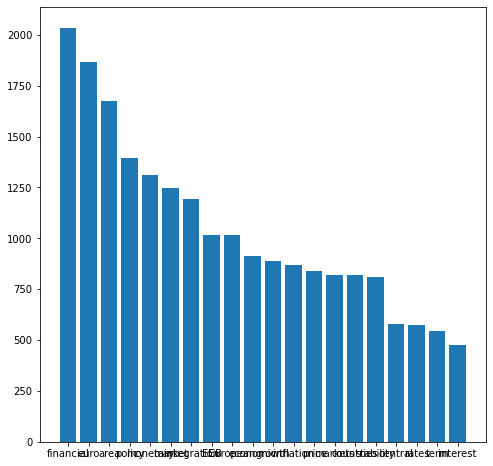

In [62]:
plt.clf()
fig, ax = plt.subplots(figsize=(8, 8))
plt.bar(x,y)

In [63]:
freq_words_year(df,2005,20)

[('financial', 2035),
 ('euro', 1865),
 ('area', 1676),
 ('policy', 1395),
 ('monetary', 1310),
 ('market', 1245),
 ('integration', 1191),
 ('ECB', 1016),
 ('European', 1015),
 ('economic', 911),
 ('growth', 887),
 ('inflation', 869),
 ('price', 840),
 ('markets', 819),
 ('countries', 819),
 ('stability', 811),
 ('central', 578),
 ('rates', 575),
 ('term', 543),
 ('interest', 477)]

In [64]:
# https://spacytextblob.netlify.app/docs/